In [56]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [57]:
with open("results_variable_dataseed.json", "r") as f:
    var_dataseed = json.load(f)
    
with open("results_variable_netseed.json", "r") as f:
    var_netseed = json.load(f)

In [58]:
print(var_dataseed)

{'iVAE_1000': [0.4565, 0.4328, 0.4933, 0.4474, 0.6259, 0.5667, 0.4465, 0.426, 0.357, 0.5597, 0.4264, 0.5107, 0.4064, 0.5783, 0.5256, 0.4082, 0.507, 0.4778, 0.3742, 0.3756, 0.3005, 0.4339, 0.4992, 0.5308, 0.5891, 0.48, 0.4952, 0.5806, 0.5736, 0.4404, 0.5934, 0.4199, 0.4804, 0.5253, 0.5694, 0.4038, 0.5631, 0.4798, 0.4462, 0.4334, 0.5305, 0.5667, 0.3785, 0.495, 0.5502, 0.4481, 0.5088, 0.5011, 0.4378, 0.4253, 0.4621, 0.575, 0.4892, 0.456, 0.5661, 0.4372, 0.4831, 0.4655, 0.3922, 0.4231, 0.4969, 0.5611, 0.4739, 0.529, 0.4513, 0.5333, 0.4727, 0.5291, 0.4532, 0.4661, 0.4743, 0.5078, 0.5307, 0.5224, 0.5736, 0.4208, 0.5931, 0.4553, 0.5257, 0.4733, 0.4973, 0.4557, 0.4264, 0.4598, 0.5207, 0.4451, 0.4463, 0.4353, 0.481, 0.4176, 0.4716, 0.5227, 0.4415, 0.4483, 0.3953, 0.4437, 0.5664, 0.5427, 0.4471, 0.4183], 'iFlow_fixed_RQNSF_AG_1000': [0.7369, 0.7518, 0.8215, 0.8839, 0.8945, 0.7338, 0.6076, 0.7198, 0.6821, 0.8519, 0.6835, 0.7394, 0.6224, 0.8784, 0.7004, 0.6989, 0.7078, 0.7129, 0.8033, 0.7671, None

In [59]:
print(var_netseed)

{'iFlow_original_RQNSF_AG_1000': [0.7036, 0.6603, 0.6804, 0.7208, 0.7166, 0.797, 0.6966, 0.7601, 0.5855, 0.7206, 0.6858, 0.8254, 0.7777, 0.6714, 0.7176, 0.6671, 0.6898, 0.6332, 0.6113, 0.7582, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], 'iVAE_1000': [0.4804, 0.4095, 0.447, 0.4978, 0.4618, 0.5026, 0.4551, 0.4499, 0.4859, 0.4509, 0.4264, 0.4585, 0.5516, 0.4927, 0.439, 0.488, 0.4753, 0.5233, 0.4582, 0.478]}


In [60]:
for key in var_dataseed.keys():
    scores = np.array(var_dataseed[key])
    scores = scores[np.where(scores)][:20]
    print(f"Using {key:>30} the average MCC score is {np.round(np.mean(scores),4):>7} with std = {np.round(np.std(scores),4)}")

Using                      iVAE_1000 the average MCC score is  0.4701 with std = 0.0726
Using      iFlow_fixed_RQNSF_AG_1000 the average MCC score is  0.7499 with std = 0.0804
Using    iFlow_removed_RQNSF_AG_1000 the average MCC score is  0.6446 with std = 0.0638
Using   iFlow_original_RQNSF_AG_1000 the average MCC score is  0.7131 with std = 0.0585
Using  iFlow_original_RQNSF_AG_10000 the average MCC score is   0.735 with std = 0.0619
Using                     iVAE_10000 the average MCC score is  0.4899 with std = 0.0481
Using iFlow_original_PlanarFlow_1000 the average MCC score is   0.619 with std = 0.0421
Using  iFlow_removed_PlanarFlow_1000 the average MCC score is  0.5786 with std = 0.0522


In [61]:
def plot_multiple(keys, labels):
    for key, label in zip(keys, labels):
        scores = np.array(var_dataseed[key])
        scores = scores[np.where(scores)][:20]
        x = np.linspace(1, 20, 20)
        mean = np.round(np.mean(scores), 4)
        std = np.round(np.std(scores),4)
        plt.plot(x, scores, label=f"{label}: {mean}({std})")
    plt.ylim([0.35, 0.9])
    plt.xlabel("Seed number")
    plt.ylabel("MCC")
    plt.legend()
    plt.xticks([i for i in range(0, 21, 5)])
    plt.show()

In [62]:
def plot_multiple_seeds(key, datas, labels):
    for data, label in zip(datas, labels):
        scores = np.array(data[key])
        scores = scores[np.where(scores)][:20]
        x = np.linspace(1, 20, 20)
        mean = np.round(np.mean(scores), 4)
        std = np.round(np.std(scores),4)
        plt.plot(x, scores, label=f"{label}: {mean}({std})")
    plt.ylim([0.35, 0.9])
    plt.xlabel("Seed number")
    plt.ylabel("MCC")
    plt.legend()
    plt.xticks([i for i in range(0, 21, 5)])
    plt.show()

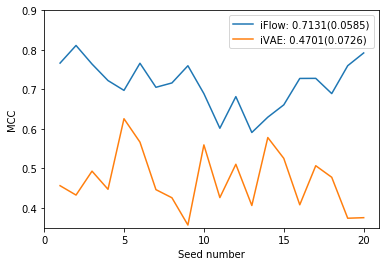

In [63]:
# First lets plot regular iFlow against iVAE
plot_multiple(["iFlow_original_RQNSF_AG_1000", "iVAE_1000"], ["iFlow", "iVAE"])

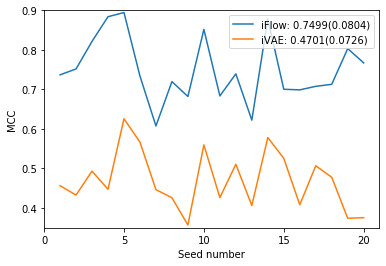

In [64]:
# Now lets compare the different versions of iFlow (fixed, original and removed)
plot_multiple(["iFlow_fixed_RQNSF_AG_1000", "iVAE_1000"], ["iFlow", "iVAE"])


In [65]:
# now lets compare using different  way of fixing the seed.

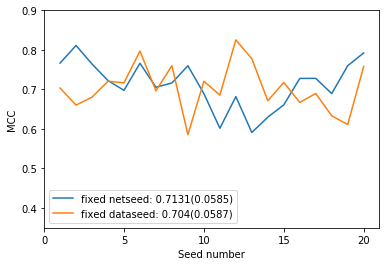

In [66]:
#iFlow
plot_multiple_seeds("iFlow_original_RQNSF_AG_1000", [var_dataseed, var_netseed], ["fixed netseed", "fixed dataseed"])

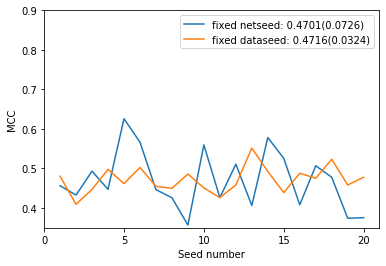

In [67]:
# iVAE
plot_multiple_seeds("iVAE_1000", [var_dataseed, var_netseed], ["fixed netseed", "fixed dataseed"])

In [68]:
# Now lets compare for 

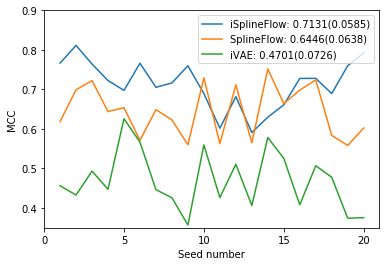

In [69]:
plot_multiple(["iFlow_original_RQNSF_AG_1000", "iFlow_removed_RQNSF_AG_1000", "iVAE_1000"], ["iSplineFlow", "SplineFlow", "iVAE"])

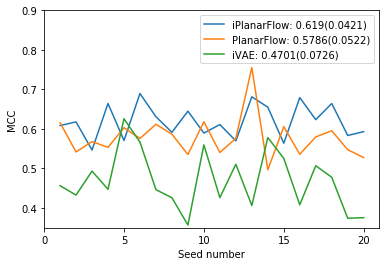

In [70]:
plot_multiple(["iFlow_original_PlanarFlow_1000", "iFlow_removed_PlanarFlow_1000", "iVAE_1000"], ["iPlanarFlow", "PlanarFlow", "iVAE"])